---
# Importing and Querying Shapefiles in PostGIS

Date: 27-11-2019 <br>
Concept version: 0.9 <br>
Author: Pieter Lems  <br>

© Copyright 2019 Ministerie van Defensie


## Contents of notebook
- Importing the required modules
- World port index
    - Reading the dataset
    - Validating the dataset
    - Connecting to the database
      - Create Docker PostGIS database (if needed)
      - Create the database
      - Connect to the database
      - Add the postgis exstensions
    - Importing WPI using shp2pgsql
    - Querying the data 
        - use-case
        - visualize the use-case 
        
#### Dataset used in notebook. ("~/GeoStack-Course/Course-Datasets/SHP/World-Port-Index/") This is noted as ("../../../Course-Datasets/SHP/World-Port-Index/") in the notebook.
- World Port Index dataset : ../../../Course-Datasets/SHP/World-Port-Index/WPI.shp   
---

### Importing the required modules

In [1]:
import geopandas as gpd
import pandas as pd
import psycopg2
import cartopy        
import cartopy.crs as ccrs 
import cartopy.feature as cfeature 
import matplotlib.pyplot as plt

---
### Reading the World Port Index database

In [2]:
World_Port_Index = gpd.read_file("../../../Course-Datasets/SHP/World-Port-Index/WPI.shp")

### Connecting to the database

#### Create docker container (If needed)
Uncomment to download the image and create the container

In [3]:
#!docker run -d -p 5432:5432 --name postgres-db mdillon/postgis:9.6-alpine

#### Create Database (If not exists) 

In [4]:
!PGPASSWORD="geostack" createdb "World_Port_Index_Database" -h localhost -p 5432 -U postgres

#### Connect to the database

In [5]:
conn = psycopg2.connect(host='localhost',
                        dbname='World_Port_Index_Database',
                        user='postgres',
                        password='geostack',
                        port=5432)

cursor = conn.cursor()

#### Add PostGIS Exstensions (If not exists)

In [6]:
cursor.execute('CREATE EXTENSION IF NOT EXISTS postgis;')
cursor.execute('CREATE EXTENSION IF NOT EXISTS postgis_topology;')
conn.commit()
conn.close()

---

### Import World Port Index using SHP2PGSQL

To import a dataset in a PostGIS database you use the following command: <br>
##### shp2pgsql -I -s 4326 {path to shapefile} {name of table to create} | PGPASSWORD="{db password}" psql -U {db user} -h {location where database is hosted} -d {name of db}

In [7]:
!shp2pgsql -I -s 4326 '../Data/World_Port_Index/WPI.shp' WPI | PGPASSWORD="geostack" psql -h localhost -p 5432 -U postgres -d World_Port_Index_Database

Field index_no is an FTDouble with width 16 and precision 6
Field region_no is an FTDouble with width 16 and precision 6
Field latitude is an FTDouble with width 16 and precision 6
Field longitude is an FTDouble with width 16 and precision 6
Field lat_deg is an FTDouble with width 16 and precision 6
Field lat_min is an FTDouble with width 16 and precision 6
Field long_deg is an FTDouble with width 16 and precision 6
Field long_min is an FTDouble with width 16 and precision 6
Field tide_range is an FTDouble with width 16 and precision 6
Shapefile type: Point
Postgis type: POINT[2]
SET
SET
BEGIN
CREATE TABLE
ALTER TABLE
              addgeometrycolumn               
----------------------------------------------
 public.wpi.geom SRID:4326 TYPE:POINT DIMS:2 
(1 row)

INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSERT 0 1
INSER

## Querying the data

### Function  fetch_data()
This function opens a connection, retrieves the data and returns a populated dataframe.

- parameter 1 = The query to perform on the database

In [8]:
def fetch_data(query):
    conn = psycopg2.connect(host='localhost',
                        dbname='World_Port_Index_Database',
                        user='postgres',
                        password='geostack',
                        port=5432)
    cursor = conn.cursor()
    
    cursor.execute(query)
    return pd.DataFrame(cursor.fetchall())

    if(conn):
        cursor.close()
        conn.close()
        print("PostgreSQL connection is closed")

### Use-Case
We want to display all ports belonging to:

- Russia = Brown
- China = Yellow
- America = Blue
- Netherlands = Red


In [9]:
Russia = fetch_data("select latitude,longitude from WPI where country='RU';")
China = fetch_data("select latitude,longitude from WPI where country='CN';")
America = fetch_data("select latitude,longitude from WPI where country='US';")
Netherlands =  fetch_data("select latitude,longitude from WPI where country='NL';")

#### Visualize Use-Case

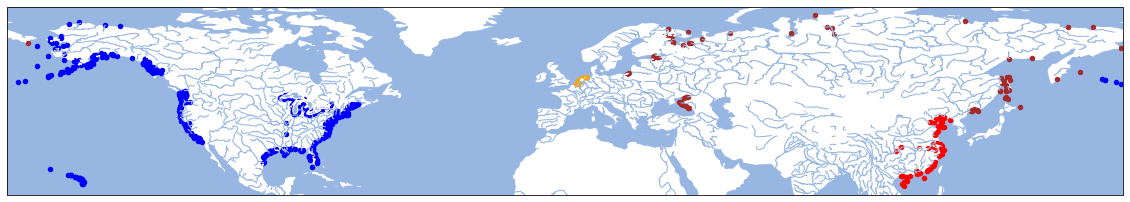

In [10]:
plt.figure(figsize = (20, 20))

m = plt.axes(projection=ccrs.PlateCarree())

m.add_feature(cartopy.feature.LAND.with_scale('10m'), facecolor = "white")

m.add_feature(cfeature.OCEAN)

m.add_feature(cfeature.LAKES.with_scale('10m'), edgecolor = 'white')

m.add_feature(cfeature.RIVERS.with_scale('10m'))

m.scatter(Russia[1], Russia[0],color="brown", s = 20)

m.scatter(China[1], China[0],color="red", s = 20)

m.scatter(America[1], America[0],color="blue", s = 20)

m.scatter(Netherlands[1], Netherlands[0],color="orange", s = 20)